# Semantic segmentation using pytorch и deeplabv3

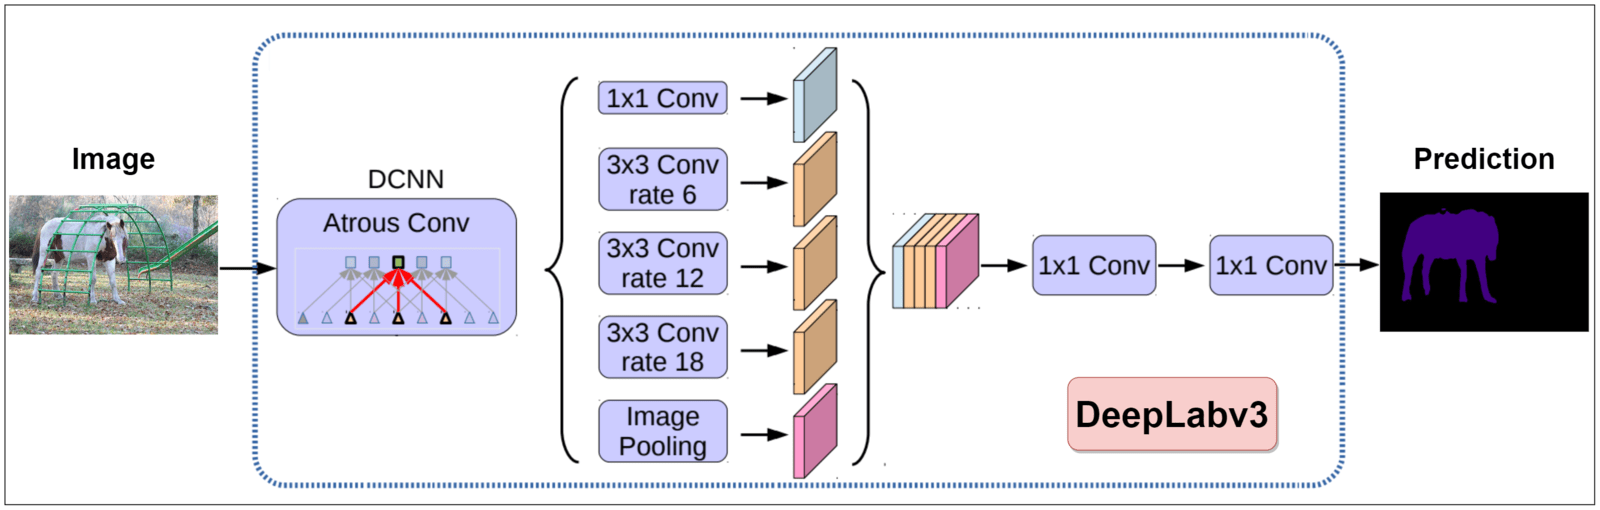

# I was working in google colab using kaggle api

In [ ]:
!pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/













In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from sklearn.metrics import f1_score, roc_auc_score
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import random_split, DataLoader, Dataset
import torchvision.transforms as transforms
from torchvision.io import read_image, ImageReadMode
import torchvision
from torchvision.datasets.vision import VisionDataset
from tqdm.notebook import tqdm
from PIL import Image
from glob import glob
import os
import time
import copy
import csv

In [ ]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  
# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d bulentsiyah/semantic-drone-dataset

In [ ]:
!unzip semantic-drone-dataset.zip

In [ ]:
image_path = '/content/dataset/semantic_drone_dataset/original_images'
mask_path = '/content/dataset/semantic_drone_dataset/label_images_semantic'



In [ ]:
labels = pd.read_csv('/content/class_dict_seg.csv')

In [ ]:
labels.head()

,name,r,g,b
0,unlabeled,0,0,0
1,paved-area,128,64,128
2,dirt,130,76,0
3,grass,0,102,0
4,gravel,112,103,87


In [ ]:
len(labels)

24

In [ ]:
classes = labels.name.values.tolist()
print(classes)


['unlabeled', 'paved-area', 'dirt', 'grass', 'gravel', 'water', 'rocks', 'pool', 'vegetation', 'roof', 'wall', 'window', 'door', 'fence', 'fence-pole', 'person', 'dog', 'car', 'bicycle', 'tree', 'bald-tree', 'ar-marker', 'obstacle', 'conflicting']


In [ ]:
length = len(os.listdir(image_path))

## Dataset class

In [ ]:
class DroneDataset(Dataset):
    def __init__(self, imgs_dir, masks_dir, count, is_val = False):
        self.imgs_dir = imgs_dir
        self.masks_dir = masks_dir

        imgs_paths = os.listdir(self.imgs_dir)
        imgs_paths.sort()

        mask_paths = os.listdir(self.masks_dir)
        mask_paths.sort()

        self.is_val = is_val
        if not is_val:  # для разделения на train/val в процессе
            self.imgs_paths = imgs_paths[:count]
            self.mask_paths = mask_paths[:count]
        else:
            self.imgs_paths = imgs_paths[-count:]
            self.mask_paths = mask_paths[-count:]

    def __len__(self):
        return len(self.imgs_paths)

    def __getitem__(self, idx):
        img = read_image(os.path.join(self.imgs_dir, self.imgs_paths[idx]), ImageReadMode.RGB)
        mask = read_image(os.path.join(self.masks_dir, self.mask_paths[idx]), ImageReadMode.GRAY)

        return img, mask

# Transforms

In [ ]:
torchvision.models.segmentation.DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1.transforms() # transforms with which model was trained

SemanticSegmentation(
    resize_size=[520]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [ ]:
def img_transform(img, mask, is_val=False, size=520):
    img = img.to(device)
    mask = mask.to(device)

    img = img.float() / 255.0

    if not is_val:
        trans_img = torch.nn.Sequential(
            transforms.Resize([size, size]),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            transforms.RandomAutocontrast(p=0.2)
        )
    else:
        trans_img = trans_img = torch.nn.Sequential(
            transforms.Resize([size, size]),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        )

    trans_mask = torch.nn.Sequential(
        transforms.Resize([size, size])
    )
    trans_img.requires_grad_(False)
    trans_mask.requires_grad_(False)

    trans_img = trans_img.to(device)
    trans_mask = trans_mask.to(device)

    img = trans_img(img)
    mask = trans_mask(mask)

    return img, mask.squeeze(1).long()

In [ ]:
train_dataset_len = int(length * 0.7)
val_dataset_len = length - train_dataset_len

train_dataset = DroneDataset(image_path, mask_path, train_dataset_len)

val_dataset = DroneDataset(image_path, mask_path, val_dataset_len, is_val=True)

In [ ]:
train_dataset[5][0].shape

torch.Size([3, 4000, 6000])

In [ ]:
train_dataset[5][1].shape

torch.Size([1, 4000, 6000])

In [ ]:
img, mask = next(iter(train_dataset))

In [ ]:
batch_size = 4

train_loader = DataLoader(train_dataset, batch_size, shuffle=True, num_workers=2)

val_loader = DataLoader(val_dataset, batch_size, shuffle=False, num_workers=2)


In [ ]:
model = torchvision.models.segmentation.deeplabv3_resnet50(weights=torchvision.models.segmentation.DeepLabV3_ResNet50_Weights.DEFAULT,
                                                    progress=True)

# By default deeplabv3 has 21 classes as an output, you need to change head for custom data

In [ ]:
from torchvision.models.segmentation.deeplabv3 import DeepLabHead
from torchvision.models.segmentation.fcn import FCNHead
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model.classifier = DeepLabHead(2048, 23)
model.aux_classifier = FCNHead(1024, 23)
model = model.to(device)


# I use Cross Entropy loss, you can also try different ones, for example, Dice loss. You can look on implementations here   
## https://www.kaggle.com/code/bigironsphere/loss-function-library-keras-pytorch

In [ ]:
from torch.nn import CrossEntropyLoss
import torch.nn.functional as F

loss = CrossEntropyLoss().to(device)
learning_rate = 0.01
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)



## Pixel accuracy

In [ ]:
def pixel_accuracy(mask, output):
    output_softmax = F.softmax(output, dim=1)
    output_argmax = torch.argmax(output_softmax, dim=1)

    bool_tensor = (torch.flatten(mask)) == (torch.flatten(output_argmax))

    return torch.sum(bool_tensor) / torch.numel(bool_tensor)

# Train 

In [ ]:
from tqdm import tqdm
epoch_count = 30

train_losses = []
val_losses = []

train_accs = []
val_accs = []
es_steps = 3
count_steps = 0

train_len = len(train_loader)
val_len = len(val_loader)
print(train_len)
print(val_len)

best_score = 1e10

for epoch in range(epoch_count):
    if count_steps >= es_steps:
        print("Early stopping!")
        break

    train_loss_sum = 0
    train_pixel_acc = 0

    model.train()
    for img_batch, mask_batch in tqdm(train_loader):
        img_batch = img_batch.to(device, non_blocking=True)
        mask_batch = mask_batch.to(device, non_blocking=True)
        img_batch, mask_batch = img_transform(img_batch, mask_batch, is_val=False)

        optimizer.zero_grad()

        output_batch = model(img_batch)
        loss_value = loss(output_batch['out'], mask_batch)

        train_pixel_acc += pixel_accuracy(mask_batch, output_batch['out']).detach()
        train_loss_sum += loss_value.detach()

        loss_value.backward()
        optimizer.step()
        
        del output_batch

    train_loss = train_loss_sum / train_len
    train_acc = train_pixel_acc / train_len

    train_losses.append(train_loss)
    train_accs.append(train_acc)

    print(f"Epoch {epoch} / {epoch_count} | train loss = {train_loss} | train acc = {train_acc}")

    model.eval()

    val_loss_sum = 0
    val_pixel_acc = 0

    for img_batch, mask_batch in tqdm(val_loader):
        img_batch = img_batch.to(device, non_blocking=True)
        mask_batch = mask_batch.to(device, non_blocking=True)
        img_batch, mask_batch = img_transform(img_batch, mask_batch, is_val=True)

        output_batch = model(img_batch)
        loss_value = loss(output_batch['out'], mask_batch)

        val_loss_sum = val_loss_sum + loss_value.detach()
        val_pixel_acc = val_pixel_acc + pixel_accuracy(mask_batch, output_batch['out']).detach()
        
        del output_batch

    val_loss = val_loss_sum / val_len
    val_acc = val_pixel_acc / val_len

    val_losses.append(val_loss)
    val_accs.append(val_acc)
    print(f"Epoch {epoch} / {epoch_count} | val loss = {val_loss} | val acc = {val_acc}")

    if val_loss < best_score:
        best_score = val_loss
        count_steps = 0
        torch.save(model, "best_model.pt")
    else:
        count_steps += 1


70

30


  0%|          | 0/70 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).

  warnings.warn(

100%|██████████| 70/70 [02:23<00:00,  2.05s/it]


Epoch 0 / 30 | train loss = 2.1927378177642822 | train acc = 0.3756603002548218


100%|██████████| 30/30 [00:50<00:00,  1.68s/it]


Epoch 0 / 30 | val loss = 1.8879438638687134 | val acc = 0.49579933285713196


100%|██████████| 70/70 [02:07<00:00,  1.82s/it]


Epoch 1 / 30 | train loss = 1.9176974296569824 | train acc = 0.46691960096359253


100%|██████████| 30/30 [00:45<00:00,  1.53s/it]


Epoch 1 / 30 | val loss = 7.197688579559326 | val acc = 0.48958301544189453


100%|██████████| 70/70 [02:05<00:00,  1.79s/it]


Epoch 2 / 30 | train loss = 1.73320734500885 | train acc = 0.5060960054397583


100%|██████████| 30/30 [00:47<00:00,  1.57s/it]


Epoch 2 / 30 | val loss = 1.8943663835525513 | val acc = 0.4266534447669983


100%|██████████| 70/70 [02:03<00:00,  1.76s/it]


Epoch 3 / 30 | train loss = 1.6038542985916138 | train acc = 0.5261707901954651


100%|██████████| 30/30 [00:44<00:00,  1.49s/it]


Epoch 3 / 30 | val loss = 1.449715256690979 | val acc = 0.5494044423103333


100%|██████████| 70/70 [01:59<00:00,  1.71s/it]


Epoch 4 / 30 | train loss = 1.5804507732391357 | train acc = 0.5281729698181152


100%|██████████| 30/30 [00:45<00:00,  1.50s/it]


Epoch 4 / 30 | val loss = 1.7535260915756226 | val acc = 0.4946329891681671


100%|██████████| 70/70 [02:00<00:00,  1.71s/it]


Epoch 5 / 30 | train loss = 1.5620498657226562 | train acc = 0.530703604221344


100%|██████████| 30/30 [00:45<00:00,  1.51s/it]


Epoch 5 / 30 | val loss = 1.4682961702346802 | val acc = 0.5449122190475464


100%|██████████| 70/70 [02:00<00:00,  1.73s/it]


Epoch 6 / 30 | train loss = 1.4278045892715454 | train acc = 0.5570023059844971


100%|██████████| 30/30 [00:45<00:00,  1.52s/it]


Epoch 6 / 30 | val loss = 1.5187551975250244 | val acc = 0.5413453578948975

Early stopping!


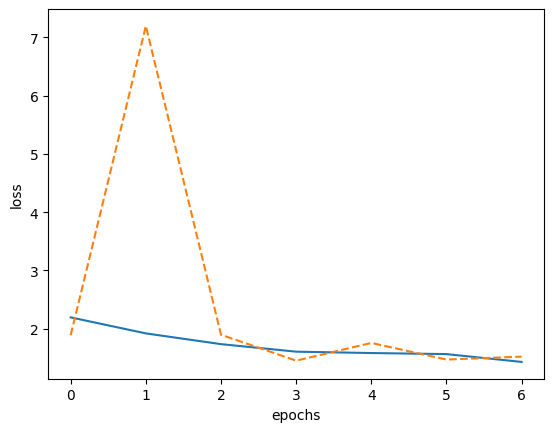

In [ ]:
import matplotlib.pyplot as plt
train_losses = [x.cpu().item() for x in train_losses]
val_losses = [x.cpu().item() for x in val_losses]
plt.plot(train_losses, linestyle="-")
plt.plot(val_losses, linestyle="--")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()


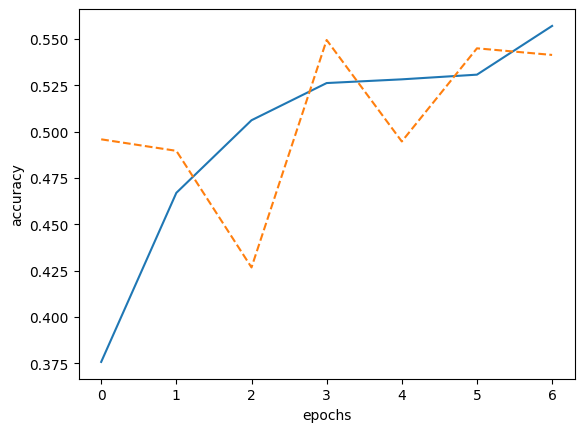

In [ ]:
train_accs = [x.cpu().item() for x in train_accs]
val_accs = [x.cpu().item() for x in val_accs]

plt.plot(train_accs, linestyle="-")
plt.plot(val_accs, linestyle="--")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.show()

# Inference

In [ ]:
model.eval()

In [92]:
label_map = np.array([
    (0, 0, 0),  # unlabeled
    (128, 64, 128),  # paved-area
    (130, 76, 0),  # dirt
    (0, 102, 0),  # grass
    (112, 103, 87),  # gravel
    (28, 42, 168),  # water
    (48, 41, 30),  # rocks
    (0, 50, 89), # pool
    (107, 142, 35),  # vegetation
    (70, 70, 70),  # roof
    (102, 102, 156),  # wall
    (254, 228, 12),  # window
    (254, 148, 12),  # door
    (190, 153, 153),  # fence
    (153, 153, 153),  # fence-pole
    (255, 22, 96),  # person
    (102, 51, 0),  # dog
    (9, 143, 150),  # car
    (119, 11, 32),  # bicycle
    (51, 51, 0),  # tree
    (190, 250, 190),  # bald-tree
    (112, 150, 146),  # art-marker
    (2, 135, 115), # obstacle
    (255, 0, 0), # conflicting
])

In [93]:
def draw_segmentation_map(outputs):
    labels = torch.argmax(outputs.squeeze(), dim=0).numpy()
  
    # Create 3 Numpy arrays containing zeros.
    # Later each pixel will be filled with respective red, green, and blue pixels
    # depending on the predicted class.
  
    red_map   = np.zeros_like(labels).astype(np.uint8)
    green_map = np.zeros_like(labels).astype(np.uint8)
    blue_map  = np.zeros_like(labels).astype(np.uint8)
  
    for label_num in range(0, len(label_map)):
        index = labels == label_num
         
        R, G, B = label_map[label_num]
  
        red_map[index]   = R
        green_map[index] = G
        blue_map[index]  = B
  
    segmentation_map = np.stack([red_map, green_map, blue_map], axis=2)
    return segmentation_map
  
  
def image_overlay(image, segmented_image):
    alpha = 1  # transparency for the original image
    beta  = 0.8  # transparency for the segmentation map
    gamma = 0  # scalar added to each sum
  
    image = np.array(image)
    segmented_image = cv2.cvtColor(segmented_image, cv2.COLOR_RGB2BGR)
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
     
    cv2.addWeighted(image, alpha, segmented_image, beta, gamma, image)
  
    return image

In [94]:
imgs_paths = os.listdir(image_path)
imgs_paths.sort()

In [100]:
def perform_inference(model=model ,imgs_paths=imgs_paths, num_images=10, image_dir='/content/dataset/semantic_drone_dataset/original_images/', device='cpu'):
     
     
    device = device if device is not None else ("cuda" if torch.cuda.is_available() else "cpu")

    model.to(device)
    preprocess = transforms.Compose([
      transforms.Resize([520, 520]),
      transforms.ToTensor(),
      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    # Load image handles for the validation set.
  
    # Randomly select 'num_images' from the whole set for inference.
    selected_images = np.random.choice(imgs_paths, num_images, replace=False)
  
    # Iterate over selected images
    for img_name in selected_images:
         
        # Load and pre-process image.
        image_path = os.path.join(image_dir, img_name)
        img_raw = Image.open(image_path).convert("RGB")
        W, H = img_raw.size[:2]
        img_t = preprocess(img_raw)
        img_t = torch.unsqueeze(img_t, dim=0).to(device)
  
        # Model Inference
        with torch.no_grad():
            output = model(img_t)["out"].cpu()
  
        # Get RGB segmentation map
        segmented_image = draw_segmentation_map(output)
  
        # Resize to original image size
        segmented_image = cv2.resize(segmented_image, (W, H), cv2.INTER_LINEAR)
        overlayed_image = image_overlay(img_raw, segmented_image)
         
        # Plot
        plt.figure(figsize=(12, 10), dpi=100)
        plt.subplot(1, 3, 1)
        plt.axis("off")
        plt.title("Image")
        plt.imshow(np.asarray(img_raw))
  
        plt.subplot(1, 3, 2)
        plt.title("Segmentation")
        plt.axis("off")
        plt.imshow(segmented_image)
  
        plt.subplot(1, 3, 3)
        plt.title("Overlayed")
        plt.axis("off")
        plt.imshow(overlayed_image[:, :, ::-1])
         
        plt.show()
        plt.close()

  
    return

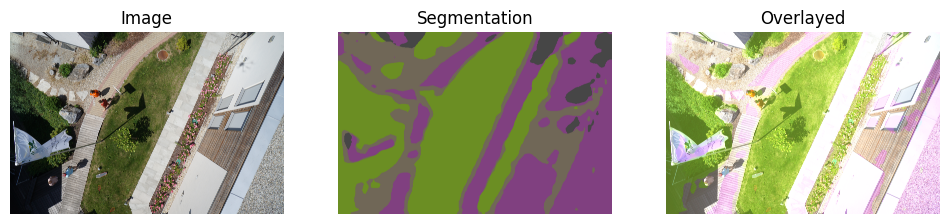

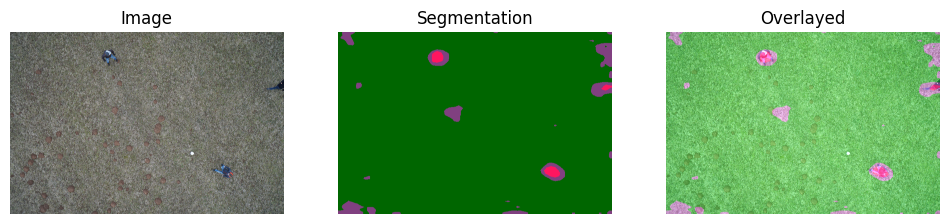

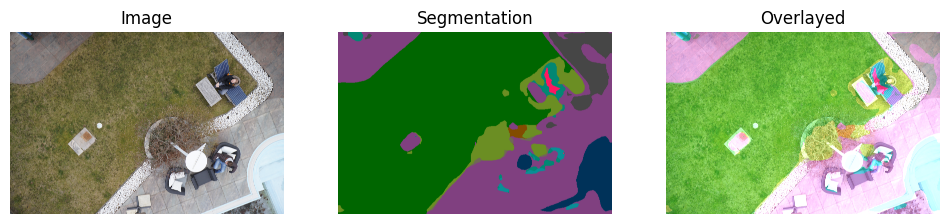

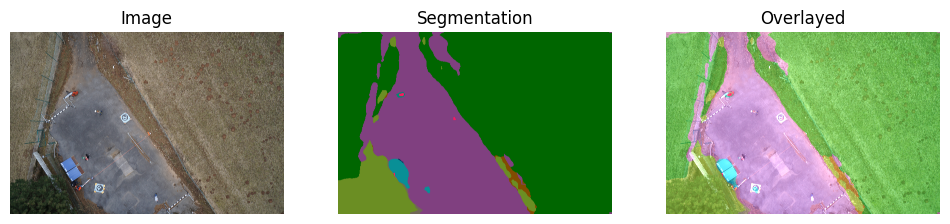

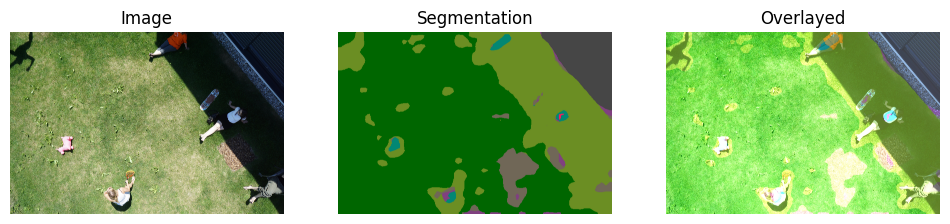

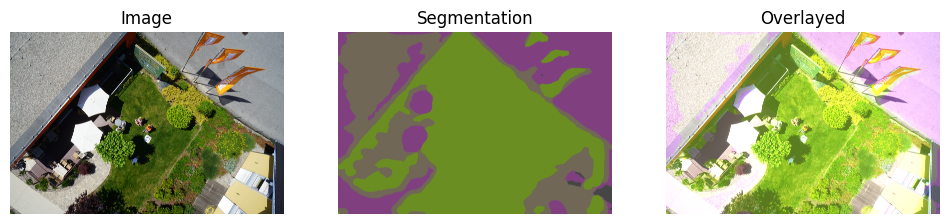

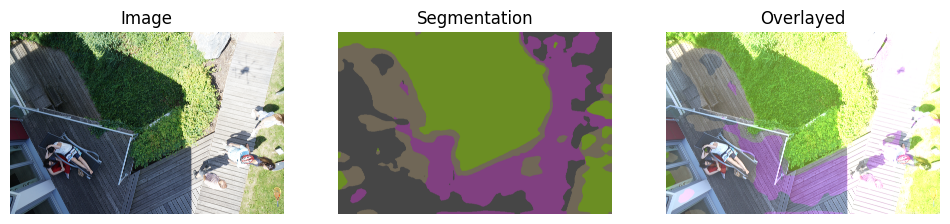

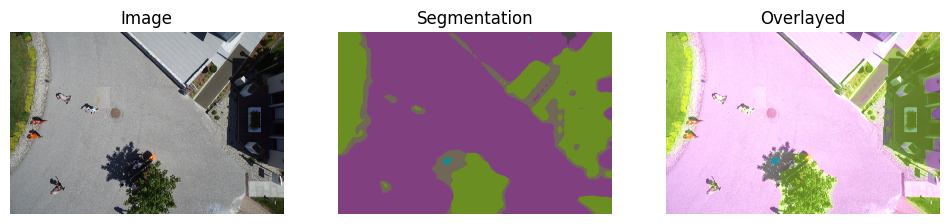

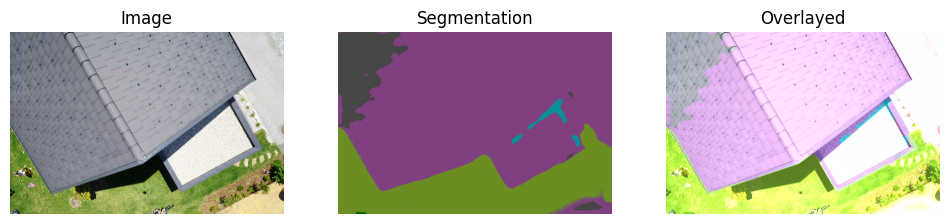

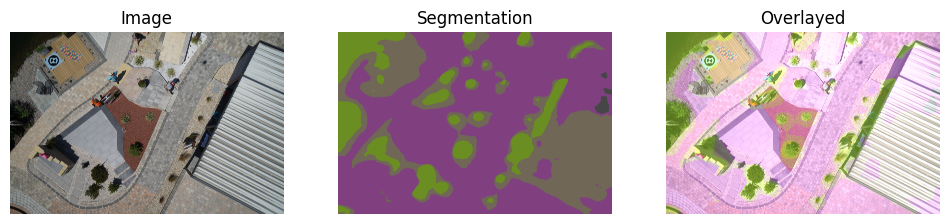

In [101]:
perform_inference()